## Image classification using pretrained models

- Imagenet - Fei-Fei Li, we will always remember you!
    - 1000 classes!
    - 1.2 million images


## Imports

In [20]:
import torch
import torchvision
from torchvision import models, transforms #  to load models
from PIL import Image, ImageDraw, ImageFont
from torchinfo import summary
import os
import cv2
import numpy as np
import requests
import matplotlib.pyplot as plt
from urllib.request import urlretrieve
from zipfile import ZipFile

## Downloading test dataset and class Names

In [4]:
def download_and_unzip(url, save_path):
    # download zip file using urllib package
    print('Downloading from:', url)
    urlretrieve(url, save_path)
    with ZipFile(save_path, 'r') as zip_ref:
        zip_ref.extractall(save_path.replace('.zip', ''))
    # os.remove(save_path)    

In [5]:
URL = r"https://www.dropbox.com/s/8srx6xdjt9me3do/TF-Keras-Bootcamp-NB07-assets.zip?dl=1"

asset_zip_path = os.path.join(os.getcwd(), 'PyTorch_BootCamp_assets.zip')

if not os.path.exists(asset_zip_path):
    download_and_unzip(URL, asset_zip_path)

In [16]:
# wget doesn't work :p, we should use curl instead
# !curl -O "https://raw.githubusercontent.com/Lasagne/Recipes/master/examples/resnet50/imagenet_classes.txt"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 21674  100 21674    0     0   600k      0 --:--:-- --:--:-- --:--:--  641k


In [34]:
# load labels
with open('imagenet_classes.txt') as f:
    # each line in the file is one class
    labels = [line.strip() for line in f.readlines()]

## Available models

1. Load a pretrained model
2. Preprocess the input image using transforms
3. Forward pass the image to model to generate predictions
4. De-code the predictions and map the class names and class_ids on postprocessing


In [7]:
# list the models in torchvision
dir(models), len(dir(models))

(['AlexNet',
  'AlexNet_Weights',
  'ConvNeXt',
  'ConvNeXt_Base_Weights',
  'ConvNeXt_Large_Weights',
  'ConvNeXt_Small_Weights',
  'ConvNeXt_Tiny_Weights',
  'DenseNet',
  'DenseNet121_Weights',
  'DenseNet161_Weights',
  'DenseNet169_Weights',
  'DenseNet201_Weights',
  'EfficientNet',
  'EfficientNet_B0_Weights',
  'EfficientNet_B1_Weights',
  'EfficientNet_B2_Weights',
  'EfficientNet_B3_Weights',
  'EfficientNet_B4_Weights',
  'EfficientNet_B5_Weights',
  'EfficientNet_B6_Weights',
  'EfficientNet_B7_Weights',
  'EfficientNet_V2_L_Weights',
  'EfficientNet_V2_M_Weights',
  'EfficientNet_V2_S_Weights',
  'GoogLeNet',
  'GoogLeNetOutputs',
  'GoogLeNet_Weights',
  'Inception3',
  'InceptionOutputs',
  'Inception_V3_Weights',
  'MNASNet',
  'MNASNet0_5_Weights',
  'MNASNet0_75_Weights',
  'MNASNet1_0_Weights',
  'MNASNet1_3_Weights',
  'MaxVit',
  'MaxVit_T_Weights',
  'MobileNetV2',
  'MobileNetV3',
  'MobileNet_V2_Weights',
  'MobileNet_V3_Large_Weights',
  'MobileNet_V3_Small_Wei

### transformations

In [8]:
transformations = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean = [0.485, 0.456, 0.406],
        std = [0.229, 0.224, 0.225]
    )])

## Instantiate the Model

Let's use the ResNet18

In [28]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# resnet 18
model = models.resnet18(weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)

# Load alexnet model
# model = models.alexnet(weights='DEFAULT')

# Load vgg16 model
# model = models.vgg16(pretrained=True)

### Model summary

In [29]:
model.eval()
model.to(DEVICE)
summary(model, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 1000]                 --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 64, 56, 56]           --
│    └─BasicBlock: 2-1                   [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│

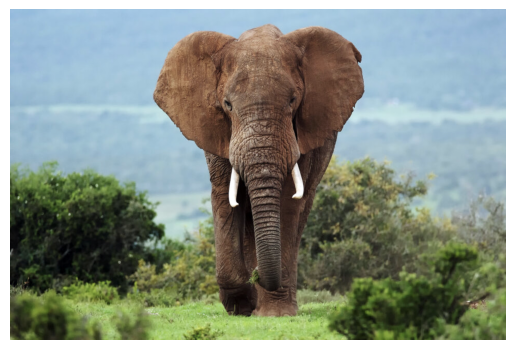

In [41]:
img = Image.open(r'PyTorch_BootCamp_assets/images/elephant.png')
plt.imshow(img)
plt.axis('off')
plt.show()

### Test the model

In [42]:
img_t = transformations(img)
batch_t = torch.unsqueeze(img_t, 0) # Add a batch dimension [C, H, W] -> [B, C, H, W]
batch_t.shape

torch.Size([1, 3, 224, 224])

In [43]:
# carry out inference
# Make sure model and the input is on the same device,by default model is on GPU weights
# if not on same device RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor)
out = model(batch_t.to(DEVICE))
out.shape

torch.Size([1, 1000])

In [49]:
_, indices = torch.sort(out.detach(), descending=True)
percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
[(labels[idx], percentage[idx].item()) for idx in indices[0][:5]]

[('African elephant, Loxodonta africana', 79.41079711914062),
 ('tusker', 17.542098999023438),
 ('Indian elephant, Elephas maximus', 3.041727066040039),
 ('Arabian camel, dromedary, Camelus dromedarius', 0.0013669930631294847),
 ('cardigan', 0.0004520685179159045)]

### Visualize

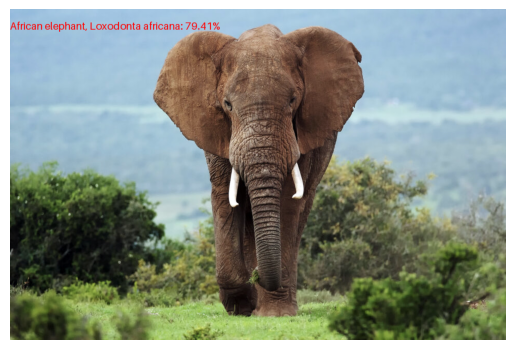

In [50]:
def visulaize_prediction(img, labels, idx, percentage):
    draw = ImageDraw.Draw(img)
    font = ImageFont.load_default(size = 20)
    
    text = f'{labels[idx]}: {percentage[idx].item():.2f}%'
    draw.text((0, 20), text, (255, 0, 0), font=font)
    return img

img_a = visulaize_prediction(img.copy(), labels, indices[0][0], percentage)
plt.imshow(img_a)
plt.axis('off')
plt.show()

In [52]:
def prediction(img_path, model, transformations, labels, device):
    img = Image.open(img_path)
    img_t = transformations(img)
    batch_t = torch.unsqueeze(img_t, 0)
    out = model(batch_t.to(device)).detach()
    _, indices = torch.sort(out, descending=True)
    percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
    return img, labels[indices[0][0]], percentage[indices[0][0]].item()

In [53]:
prediction(r'PyTorch_BootCamp_assets/images/clown-fish.png', model, transformations, labels, DEVICE)

(<PIL.PngImagePlugin.PngImageFile image mode=RGB size=3072x2183>,
 'anemone fish',
 99.94420623779297)